# Week 4 Project

Link to Kaggle Competition:

https://www.kaggle.com/competitions/nlp-getting-started/overview

Link to GitHub Repo: 

https://github.com/b5050d/5642_Week_4.git

### Problem Overview

In this Kaggle Competition a large dataset of text contained in tweets are provided. The tweets have been analyzed by humans for whether they are actually mentioning a real disaster or just use words that are similar to ones used to describe a real disaster.

### Data Description

The data provided for this Kaggle Competition comes in two files. There is a set of training data with labels provided in "train.csv" and there is a set of testing data provided in "test.csv". Also included is a sample submission csv.

In [30]:
import re
import string
import time
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow
import tensorflow as tf
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (GRU, LSTM, BatchNormalization,
                                     Bidirectional, Dense, Embedding,
                                     TextVectorization)
from tensorflow.keras.models import Sequential

data_path = ""
sample_submission_path = data_path + "sample_submission.csv"
train_path = data_path + "train.csv"
test_path = data_path + "test.csv"

## Exploratory Data Analysis

### Data Inspection

In [8]:
train_df = pd.read_csv(train_path)
print("\nTraining Data Dataframe: ")
print(train_df.head())
print("\nTraining Data Shape: ")
print(train_df.shape)

# Are all keywords NaN?
train_keywords = train_df["keyword"].unique().tolist()
print("\nTraining Data Keywords Length: ")
print(len(train_keywords))
print("\nTraining Data Keywords List: ")
print(train_keywords)

# Whats up with the location tag?
train_locations = train_df["location"].unique().tolist()
print("\nTraining Data Locations Length: ")
print(len(train_locations))
print("\nTraining Data Locations List: ")
print(train_locations)

# Whats going on with the target?
train_targets = train_df["target"].unique().tolist()
print(len(train_targets))
print(train_targets)

amounts = []
tags = []
for t in train_targets:
    amounts.append((train_df['target'] == t).sum())
    if int(t) == 0:
        tags.append("Not a disaster")
    else:
        tags.append("Is a disaster")


Training Data Dataframe: 
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Training Data Shape: 
(7613, 5)

Training Data Keywords Length: 
222

Training Data Keywords List: 
[nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident', 'ambulance', 'annihilated', 'annihilation', 'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood', 'bloody', 'blown%20up

Ok, we can see that our training data consists of 7613 tweets, and there is a column present for the text in the tweet, keywords, and locations.

In [86]:
test_df = pd.read_csv(test_path)
print(test_df.head())
test_keywords = test_df["keyword"].unique().tolist()
print(len(test_keywords))
print(test_keywords)

test_locations = test_df["location"].unique().tolist()
print(len(test_locations))
print(test_locations)
print()
try:
    for keyword in test_keywords:
        assert keyword in train_keywords
    print("All Test Keywords are Present in the Training Dataset, thats good!")
except:
    print("ALERT: Keywords in the test set do not match the training set")
print()
try:
    for location in test_locations:
        assert location in train_locations
    print("All Test Locations are Present in the Training Dataset, thats good!")
except:
    print("ALERT: Locations in the test set do not match the train set")

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
222
[nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident', 'ambulance', 'annihilated', 'annihilation', 'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging', 'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse', 'buildings%20burning', 'buildings%20on%20fire', 'burned', 'burning', 'burning%20buildings', 'bush%20fires', 'casual

The Test data is very similar to the Training data. Although it lacks the label.

### Data Visualization

Lets start by taking a look at the balance of tweets between what is not considered a disaster and what is

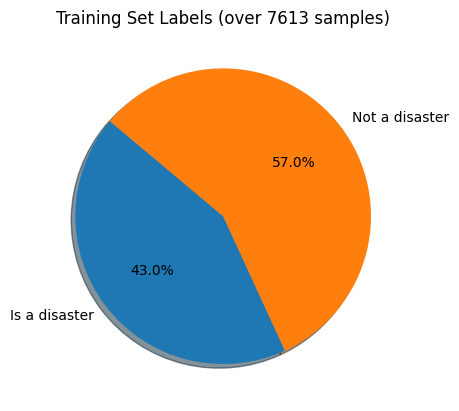

In [6]:
# Visualize using a pie chart
plt.pie(
    amounts,
    labels=tags,
    autopct='%1.1f%%',
    startangle=140,
    shadow=True
    )
plt.title(f"Training Set Labels (over {len(train_df)} samples)")
plt.show()

This is a reasonable balance. If it were any more skewed, it would probably be a good idea to change the balance so that there is a set even amount of samples in both categories.

### Data Cleaning

Based on the Data Cleaning, we have a few tasks to do to prepare our data to train our model on:
- We will drop the "location" and "keyword" columns from our dataframe as these are too variable to really pick up on.
- We will perform some basic cleaning of our data which involves removing punctuation, special characters and numbers

In [94]:
#Reload original data to avoid errors when starting from this cell
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
ids = test_df['id'].tolist()

# Drop the "location" column
train_df = train_df.drop(['keyword', 'location', 'id'], axis=1)
test_df = test_df.drop(['keyword', 'location', 'id'], axis=1)

def basic_cleaning(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d', '', text)
    text = text.lower()
    # return text

    stop_words = set(stopwords.words('english'))
    unclean_words = word_tokenize(text)
    cleaned_text_list = [i for i in unclean_words if i not in stop_words and i not in string.punctuation]
    cleaned_text = " ".join(cleaned_text_list)
    return cleaned_text

# Apply cleaning to each tweet
train_df['text'] = train_df['text'].apply(basic_cleaning)
test_df['text'] = test_df['text'].apply(basic_cleaning)

print(train_df.head())
text_list = train_df["text"].tolist()[:10]
for i in text_list:
    print(i)

                                                text  target
0       deeds reason earthquake may allah forgive us       1
1              forest fire near la ronge sask canada       1
2  residents asked shelter place notified officer...       1
3  people receive wildfires evacuation orders cal...       1
4  got sent photo ruby alaska smoke wildfires pou...       1
deeds reason earthquake may allah forgive us
forest fire near la ronge sask canada
residents asked shelter place notified officers evacuation shelter place orders expected
people receive wildfires evacuation orders california
got sent photo ruby alaska smoke wildfires pours school
rockyfire update california hwy closed directions due lake county fire cafire wildfires
flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
im top hill see fire woods
theres emergency evacuation happening building across street
im afraid tornado coming area


Ok, now lets split the data into testing and training sets:

In [88]:
X = train_df["text"]
y = train_df["target"]

submission_data = test_df["text"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Next, we need to vectorize the text data. This involves creating a numerical list representation of each word where similarity to other words is expressed and encoded.

In [ ]:
# Set up the Text Vectorization to create lists of values for each word
vocabulary_size = 10000  # Default
sequence_length = 50  # Default

vectorizer = TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=sequence_length,
    output_mode='int'
)

vectorizer.adapt(X_train)

X_train_vectorized = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test_vectorized = vectorizer(np.array([[s] for s in X_test])).numpy()
submission_data_vectorized = vectorizer(np.array([[s] for s in submission_data])).numpy()


### Plan of Analysis

- Conduct a Series of Experiments on Model Architecture and Hyperparameters to choose a Final Model
- Train and Test the Final Model for a final result

## Model Architecture
Ok first, lets establish some basic methods to help us run experiments on different model architectures

In [8]:
# Lets Build a Timer
class Timer:
    """
    Simple Timer to help us analyze the efficiency of our models
    """
    
    def __init__(self):
        """
        Set up the class
        """
        self.start_time = 0
        self.end_time = 0

    def start(self):
        """
        Start the timer
        """
        self.start_time = time.time()
        print("Started Timer")

    def stop(self):
        """
        Stop the timer
        """
        self.stop_time = time.time()
        print("Stopped Timer")

    def get_time(self):
        """
        Get the timer on the clock (an integer value of seconds)
        """
        ans = self.stop_time - self.start_time
        ans = int(ans)
        print("Time on the clock : {}".format(ans))
        return ans

In [9]:
def perform_experiment(experiment_models, X_train, y_train, X_test, y_test, num_epochs):
    """
    Perform an Experiment by training the models
    and extracting some important information
    """
    print(num_epochs)
    exp_histories = []
    exp_times = []

    for model in experiment_models:
        my_timer = Timer()
        my_timer.start()

        history = model.fit(
            X_train,
            y_train,
            epochs=num_epochs,
            batch_size=32,
            validation_data=(X_test, y_test)
            )
        
        exp_histories.append(history)

        my_timer.stop()
        time_taken = my_timer.get_time()

        exp_times.append(time_taken)

    return exp_histories, exp_times

In [10]:
def perform_basic_plots(exp_num, histories, times):
    """
    Perform some basic plotting that will be useful for
    each experiment
    """
    exps = [i for i in range(len(times))]
    legend = [f"Model{e}" for e in exps]

    # Plot the Accuracy
    for h in histories:
        plt.plot(h.epoch, h.history["val_accuracy"])
    plt.title(f"Experiment {exp_num} Validation Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(legend)
    plt.grid()
    plt.show()

    # Plot the Loss
    for h in histories:
        plt.plot(h.epoch, h.history["val_loss"])
    plt.title(f"Experiment {exp_num} Validation Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(legend)
    plt.grid()
    plt.show()

    # Plot the times taken to train each model
    plt.bar(exps, times)
    plt.title(f"Experiment {exp_num} Model Fitting times")
    plt.xlabel("Model")
    plt.ylabel("Training Time [s]")

    plt.show()

### Experiment 1: Try different RNN Architectures

In order to gain a better understanding of the RNN Architectures that are available to us, we can try a Minimum Viable Product with the following architectures:
- LSTM
- GRU
- Bidirectional LSTM
- Bidirectional GRU

In [ ]:
default_units = 64
exp1_epochs = 10

to_check = [
    LSTM(default_units),
    GRU(default_units, return_sequences = False),
    Bidirectional(LSTM(default_units)),
    Bidirectional(GRU(default_units, return_sequences = False)),
]

experiment_1_models = []
for t in to_check:

    new_model = Sequential([
        Embedding(input_dim=vocabulary_size, output_dim=64, input_length=sequence_length),
        t,
        BatchNormalization(),
        Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
        ])
    
    new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    experiment_1_models.append(new_model)

histories = []
times = []

exp1_histories, exp1_times = perform_experiment(
    experiment_1_models,
    X_train_vectorized,
    y_train,
    X_test_vectorized,
    y_test,
    num_epochs=exp1_epochs,
)



10
Started Timer
Epoch 1/10
191/191 [==============================] - 10s 43ms/step - loss: 0.5256 - accuracy: 0.7340 - val_loss: 0.5835 - val_accuracy: 0.6901
Epoch 2/10
191/191 [==============================] - 8s 39ms/step - loss: 0.3174 - accuracy: 0.8731 - val_loss: 0.7044 - val_accuracy: 0.5975
Epoch 3/10
191/191 [==============================] - 7s 39ms/step - loss: 0.2179 - accuracy: 0.9190 - val_loss: 1.2121 - val_accuracy: 0.7741
Epoch 4/10
191/191 [==============================] - 8s 39ms/step - loss: 0.1663 - accuracy: 0.9450 - val_loss: 0.6411 - val_accuracy: 0.7131
Epoch 5/10
191/191 [==============================] - 8s 40ms/step - loss: 0.1348 - accuracy: 0.9544 - val_loss: 0.7799 - val_accuracy: 0.7630
Epoch 6/10
191/191 [==============================] - 8s 40ms/step - loss: 0.1181 - accuracy: 0.9622 - val_loss: 0.5697 - val_accuracy: 0.7413
Epoch 7/10
191/191 [==============================] - 8s 39ms/step - loss: 0.1084 - accuracy: 0.9662 - val_loss: 0.7677 - va

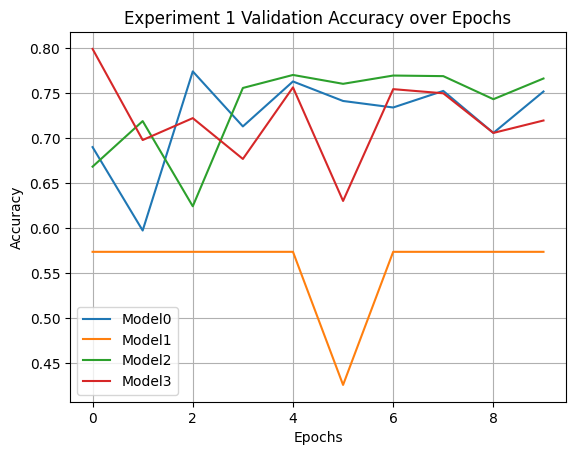

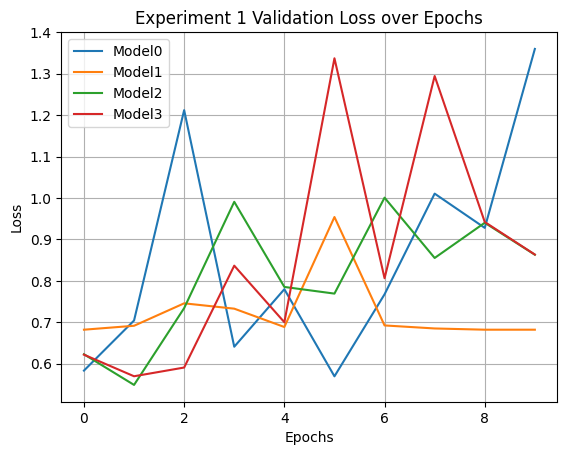

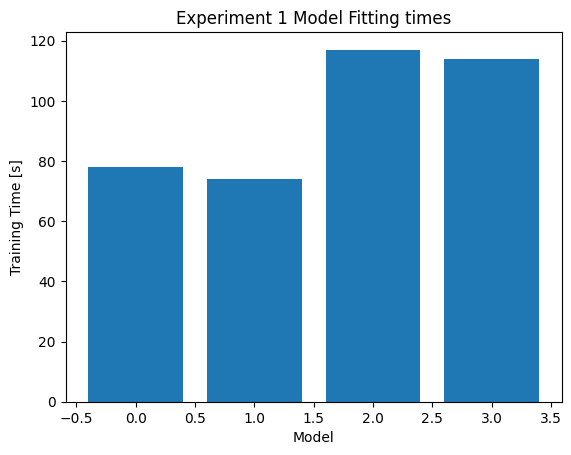

In [35]:
perform_basic_plots(1, exp1_histories, exp1_times)

From Experiment 1 we can see that the best performing model in terms of accuracy was the Model 2, which corresponds with Bidirectional LSTM. It also has the second lowest loss, and this is what will be selected for use in our model. Of note is that this architecture does perform the slowest out of all 4 tested, but not by much, and therefore it is acceptable to select this as the basis for our model. 

## Experiment 2: Adjust the Number of units

Now that we have selected a baseline architecture, it will be useful to understand the effect of the units variable on the performance of our models. This is the first variable provided to the LSTM layer and represents the number of LSTM neurons or cells present.

For this experiment, we will try 16, 32, 64, 128, and 256

In [ ]:
units = [16, 32, 64, 128, 256]
exp2_epochs = 10

experiment_2_models = []
for u in units:

    new_model = Sequential([
        Embedding(input_dim=vocabulary_size, output_dim=64, input_length=sequence_length),
        Bidirectional(LSTM(u)),
        BatchNormalization(),
        Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
        ])
    
    new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    experiment_2_models.append(new_model)

histories = []
times = []

exp2_histories, exp2_times = perform_experiment(
    experiment_2_models,
    X_train_vectorized,
    y_train,
    X_test_vectorized,
    y_test,
    num_epochs=exp2_epochs,
)


10
Started Timer
Epoch 1/10
191/191 [==============================] - 12s 43ms/step - loss: 0.5173 - accuracy: 0.7532 - val_loss: 0.6226 - val_accuracy: 0.6343
Epoch 2/10
191/191 [==============================] - 7s 37ms/step - loss: 0.2823 - accuracy: 0.8898 - val_loss: 0.6083 - val_accuracy: 0.6756
Epoch 3/10
191/191 [==============================] - 7s 36ms/step - loss: 0.1801 - accuracy: 0.9361 - val_loss: 0.6789 - val_accuracy: 0.7669
Epoch 4/10
191/191 [==============================] - 7s 36ms/step - loss: 0.1384 - accuracy: 0.9558 - val_loss: 0.6404 - val_accuracy: 0.7761
Epoch 5/10
191/191 [==============================] - 7s 36ms/step - loss: 0.1098 - accuracy: 0.9635 - val_loss: 0.7387 - val_accuracy: 0.7768
Epoch 6/10
191/191 [==============================] - 7s 37ms/step - loss: 0.0917 - accuracy: 0.9703 - val_loss: 0.7844 - val_accuracy: 0.7584
Epoch 7/10
191/191 [==============================] - 7s 38ms/step - loss: 0.0835 - accuracy: 0.9711 - val_loss: 1.0555 - va

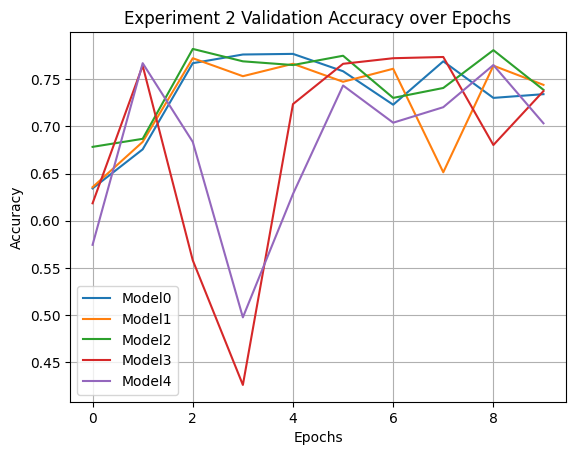

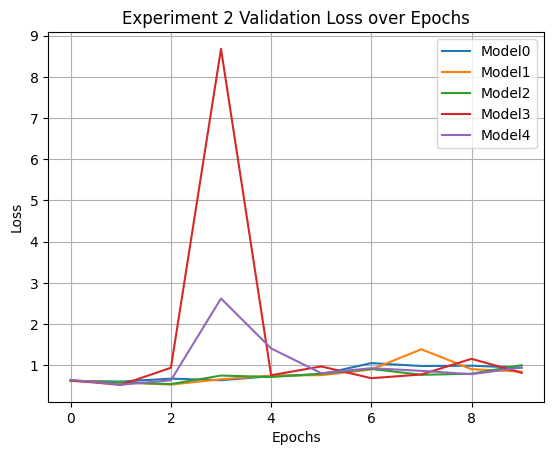

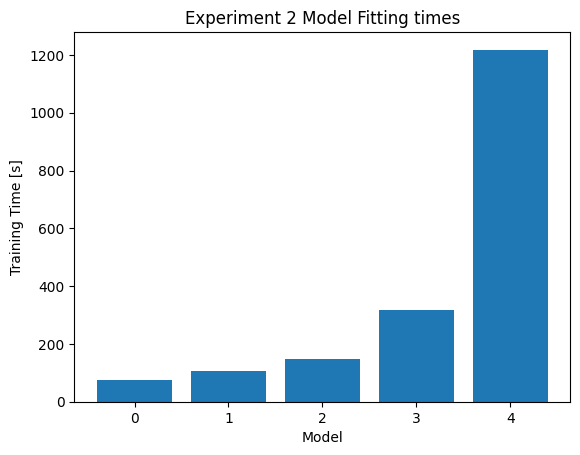

In [38]:
perform_basic_plots(2, exp2_histories, exp2_times)

From Experiment 2, we can see that as we increase the number of units, the training time increases signficantly as well. Also, we can see that there is no apparent advantage from any of the models. Therefore to keep our final model simple, we will move forward with a default value for units = 16.

## Experiment 3: Adjust the repeating Layers

For the third experiment, it will be useful to understand how the amount of repeating LSTM Bidirectional layers impacts the performance of our models. We will try 0 repeated LSTM layers, 2, 4, 8, and 16

In [ ]:
# How many repeating layers?
repetitions = [0, 2, 4, 8, 16]
u = 16 # units

exp3_epochs = 3

experiment_3_models = []
for r in repetitions:
    model_config_list = []
    model_config_list.append(Embedding(input_dim=vocabulary_size, output_dim=64, input_length=sequence_length))

    for i in range(r):
        model_config_list.append(Bidirectional(LSTM(u, return_sequences=True)))
        model_config_list.append(BatchNormalization())
    model_config_list.append(Dense(1, activation='sigmoid'))

    new_model = Sequential(model_config_list)

    new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    experiment_3_models.append(new_model)

histories = []
times = []

exp3_histories, exp3_times = perform_experiment(
    experiment_3_models,
    X_train_vectorized,
    y_train,
    X_test_vectorized,
    y_test,
    num_epochs=exp3_epochs,
)

3
Started Timer
Epoch 1/3
191/191 [==============================] - 2s 10ms/step - loss: 0.6795 - accuracy: 0.5856 - val_loss: 0.6721 - val_accuracy: 0.5985
Epoch 2/3
191/191 [==============================] - 2s 9ms/step - loss: 0.6660 - accuracy: 0.6052 - val_loss: 0.6675 - val_accuracy: 0.5986
Epoch 3/3
191/191 [==============================] - 2s 9ms/step - loss: 0.6573 - accuracy: 0.6063 - val_loss: 0.6666 - val_accuracy: 0.5987
Stopped Timer
Time on the clock : 5
Started Timer
Epoch 1/3
191/191 [==============================] - 19s 62ms/step - loss: 0.5423 - accuracy: 0.7279 - val_loss: 0.6180 - val_accuracy: 0.6942
Epoch 2/3
191/191 [==============================] - 10s 54ms/step - loss: 0.3033 - accuracy: 0.8821 - val_loss: 0.5179 - val_accuracy: 0.7580
Epoch 3/3
191/191 [==============================] - 11s 56ms/step - loss: 0.2107 - accuracy: 0.9215 - val_loss: 0.5164 - val_accuracy: 0.7686
Stopped Timer
Time on the clock : 39
Started Timer
Epoch 1/3
191/191 [===========

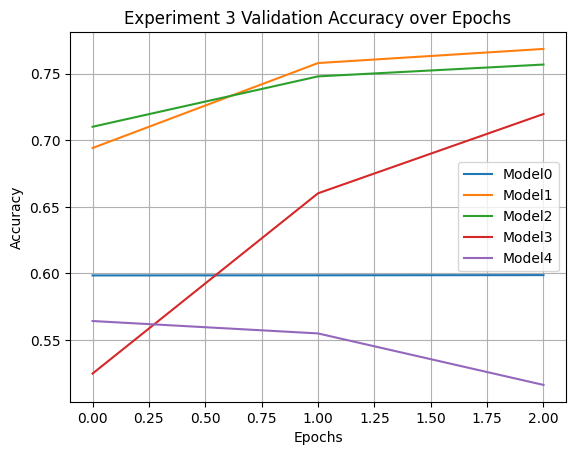

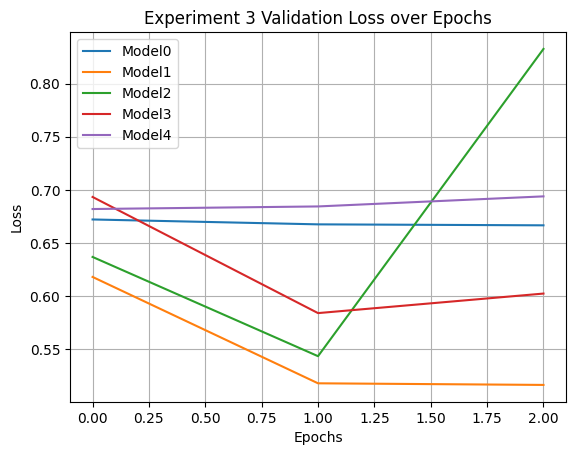

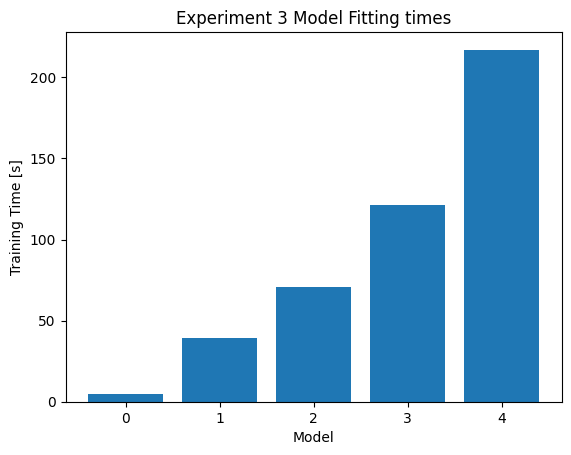

In [46]:
perform_basic_plots(3, exp3_histories, exp3_times)

From Experiment 3 we can see that more repeated layers increases the training time as expected. Interestingly, the best performing model in terms of accuracy and loss is Model 2, which corresponds with just 2 layers of LSTM-Bidirectional. This will be used for all models moving forward.

## Experiment 4: Adjust the Learning Rate 

For the fourth experiment, it will be a good idea to check how the learning rate is impacting our model performance. 

In [ ]:
learning_rates = [.005, .001, .0005, .0001, 0.00005, .00001]
u = 16 # units

exp4_epochs = 6

experiment_4_models = []
for learning_rate in learning_rates:
    model_config_list = []
    model_config_list.append(Embedding(input_dim=vocabulary_size, output_dim=64, input_length=sequence_length))

    model_config_list.append(Bidirectional(LSTM(u, return_sequences=True)))
    model_config_list.append(BatchNormalization())

    model_config_list.append(Bidirectional(LSTM(u, return_sequences=True)))
    model_config_list.append(BatchNormalization())

    model_config_list.append(Dense(1, activation='sigmoid'))

    new_model = Sequential(model_config_list)

    custom_optimizer = Adam(
        learning_rate = learning_rate,
    )

    new_model.compile(optimizer = custom_optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
    
    experiment_4_models.append(new_model)

histories = []
times = []

exp4_histories, exp4_times = perform_experiment(
    experiment_4_models,
    X_train_vectorized,
    y_train,
    X_test_vectorized,
    y_test,
    num_epochs=exp4_epochs,
)

6
Started Timer
Epoch 1/6
191/191 [==============================] - 15s 48ms/step - loss: 0.5242 - accuracy: 0.7481 - val_loss: 0.4955 - val_accuracy: 0.7814
Epoch 2/6
191/191 [==============================] - 8s 40ms/step - loss: 0.2806 - accuracy: 0.8981 - val_loss: 0.5535 - val_accuracy: 0.7670
Epoch 3/6
191/191 [==============================] - 8s 41ms/step - loss: 0.1908 - accuracy: 0.9286 - val_loss: 0.6355 - val_accuracy: 0.7522
Epoch 4/6
191/191 [==============================] - 8s 40ms/step - loss: 0.1416 - accuracy: 0.9486 - val_loss: 0.7044 - val_accuracy: 0.7603
Epoch 5/6
191/191 [==============================] - 8s 43ms/step - loss: 0.0910 - accuracy: 0.9641 - val_loss: 0.8465 - val_accuracy: 0.7676
Epoch 6/6
191/191 [==============================] - 8s 42ms/step - loss: 0.0786 - accuracy: 0.9695 - val_loss: 0.9057 - val_accuracy: 0.7686
Stopped Timer
Time on the clock : 54
Started Timer
Epoch 1/6
191/191 [==============================] - 15s 48ms/step - loss: 0.550

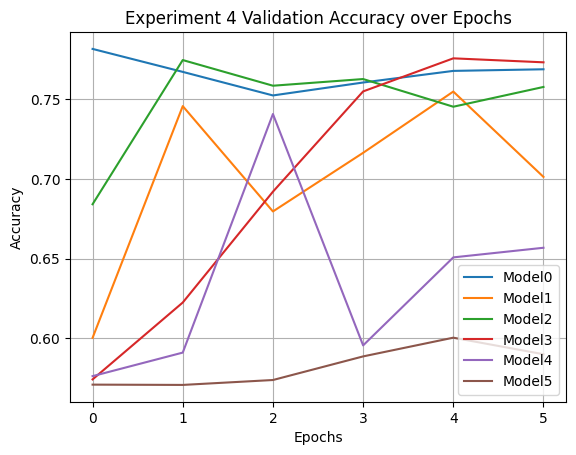

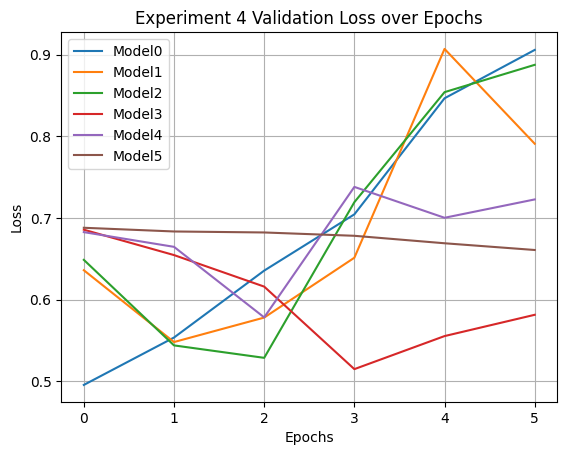

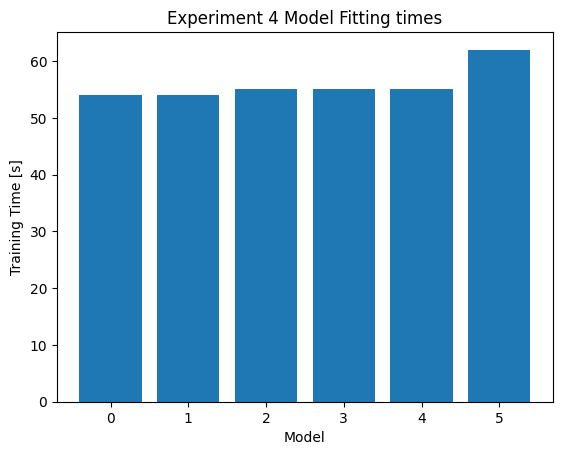

In [53]:
perform_basic_plots(4, exp4_histories, exp4_times)

From this learning rate experiment, we can see that Model 3 performs the best in terms of accuracy and loss. Also, there is no training time effect of using slower or faster learning rates. So Model 3 corresponds with .0001 and this will be used as the learning rate for the rest of this project.

## Experiment 5: Add Dense Layers

For the fifth experiment, it will be interesting to see if we can extract more performance by adding Dense layers to the end of our model.

In [ ]:
u = 16
learning_rate = 0.0001
exp5_epochs = 10

dense_layers_to_add = 3

experiment_5_models = []
for i in range(dense_layers_to_add):
    model_config_list = []
    model_config_list.append(Embedding(input_dim=vocabulary_size, output_dim=64, input_length=sequence_length))

    model_config_list.append(Bidirectional(LSTM(u, return_sequences=True)))
    model_config_list.append(BatchNormalization())

    model_config_list.append(Bidirectional(LSTM(u, return_sequences=True)))
    model_config_list.append(BatchNormalization())

    for j in range(i):
        model_config_list.append(Dense(16, activation = 'relu'))
        
    model_config_list.append(Dense(1, activation='sigmoid'))

    new_model = Sequential(model_config_list)

    custom_optimizer = Adam(
        learning_rate = learning_rate,
    )

    new_model.compile(optimizer = custom_optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
    
    experiment_5_models.append(new_model)

histories = []
times = []

exp5_histories, exp5_times = perform_experiment(
    experiment_5_models,
    X_train_vectorized,
    y_train,
    X_test_vectorized,
    y_test,
    num_epochs=exp5_epochs,
)

10
Started Timer
Epoch 1/10
191/191 [==============================] - 16s 50ms/step - loss: 0.6878 - accuracy: 0.5593 - val_loss: 0.6846 - val_accuracy: 0.5753
Epoch 2/10
191/191 [==============================] - 8s 41ms/step - loss: 0.5486 - accuracy: 0.7354 - val_loss: 0.6073 - val_accuracy: 0.6716
Epoch 3/10
191/191 [==============================] - 8s 40ms/step - loss: 0.3656 - accuracy: 0.8494 - val_loss: 0.4734 - val_accuracy: 0.7863
Epoch 4/10
191/191 [==============================] - 8s 41ms/step - loss: 0.2676 - accuracy: 0.8977 - val_loss: 0.5003 - val_accuracy: 0.7791
Epoch 5/10
191/191 [==============================] - 8s 40ms/step - loss: 0.2105 - accuracy: 0.9189 - val_loss: 0.5814 - val_accuracy: 0.7575
Epoch 6/10
191/191 [==============================] - 8s 41ms/step - loss: 0.1748 - accuracy: 0.9348 - val_loss: 0.6894 - val_accuracy: 0.7299
Epoch 7/10
191/191 [==============================] - 8s 41ms/step - loss: 0.1361 - accuracy: 0.9526 - val_loss: 0.6905 - va

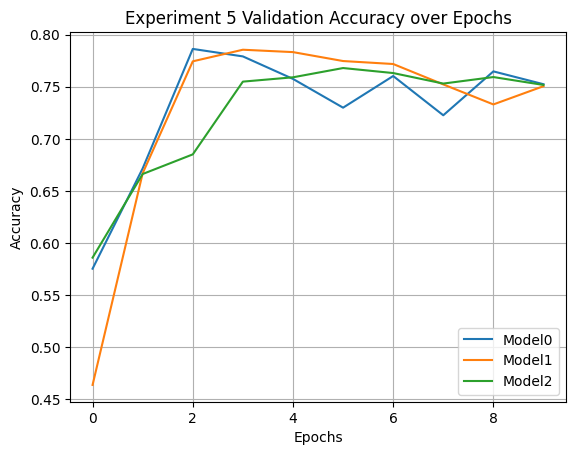

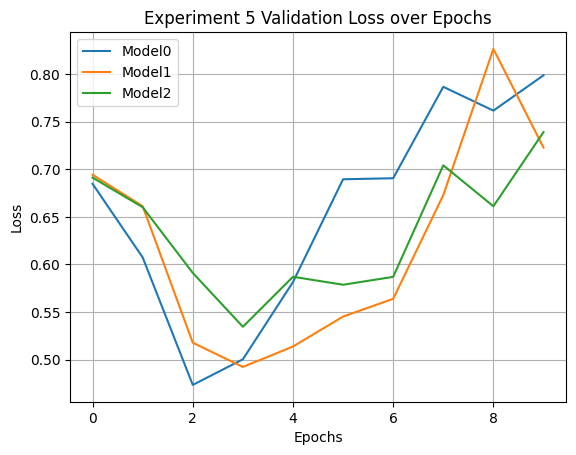

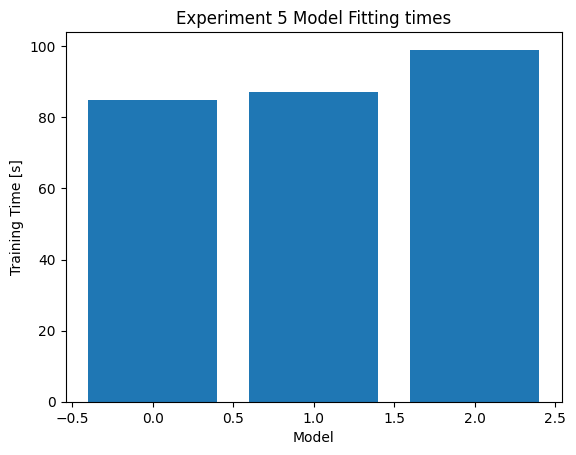

In [59]:
perform_basic_plots(5, exp5_histories, exp5_times)

From this fifth and final experiment, it can be seen that adding Dense layers at the end of our models do not have a significant impact on the performance of the models. Because of this, we will use the simplest amount of Dense layers, which is just a single Dense layer to create our output.

## Final Model

After conducting the 5 experiments, these were the results:
- Experiment 1: Bidirectional LSTM was selected as the best layer to use in our model
- Experiment 2: A number of 16 was selected for the "Units" hyperparameter
- Experiment 3: A total of 2x repeating layers of Bi-LSTM was chosen 
- Experiment 4: A learning rate of 0.0001 was selected
- Experiment 5: Additional Dense layers were not included

So using the lessons learned from these experiments, lets go ahead and build our final model.

In [ ]:
u = 16
learning_rate = 0.0001
final_epochs = 7

final_model = Sequential([
    Embedding(input_dim=vocabulary_size, output_dim=64, input_length=sequence_length),
    Bidirectional(LSTM(u, return_sequences=True)),
    BatchNormalization(),
    Bidirectional(LSTM(u, return_sequences=True)),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
custom_optimizer = Adam(
    learning_rate = learning_rate,
)

final_model.compile(optimizer = custom_optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

In [72]:
history = final_model.fit(
    X_train_vectorized,
    y_train,
    epochs=final_epochs,
    batch_size=32,
    validation_data=(X_test_vectorized, y_test),
    )

Epoch 1/7
191/191 [==============================] - 15s 47ms/step - loss: 0.7025 - accuracy: 0.5400 - val_loss: 0.6906 - val_accuracy: 0.5849
Epoch 2/7
191/191 [==============================] - 8s 40ms/step - loss: 0.5744 - accuracy: 0.7127 - val_loss: 0.6150 - val_accuracy: 0.7184
Epoch 3/7
191/191 [==============================] - 8s 40ms/step - loss: 0.3866 - accuracy: 0.8454 - val_loss: 0.4837 - val_accuracy: 0.7812
Epoch 4/7
191/191 [==============================] - 8s 40ms/step - loss: 0.2837 - accuracy: 0.8982 - val_loss: 0.5006 - val_accuracy: 0.7730
Epoch 5/7
191/191 [==============================] - 8s 40ms/step - loss: 0.2143 - accuracy: 0.9303 - val_loss: 0.5681 - val_accuracy: 0.7664
Epoch 6/7
191/191 [==============================] - 8s 40ms/step - loss: 0.1750 - accuracy: 0.9460 - val_loss: 0.6570 - val_accuracy: 0.7634
Epoch 7/7
191/191 [==============================] - 8s 41ms/step - loss: 0.1489 - accuracy: 0.9554 - val_loss: 0.6870 - val_accuracy: 0.7630


## Results and Analysis

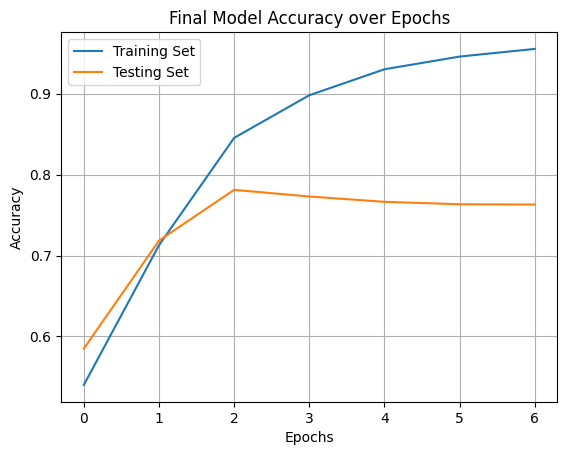

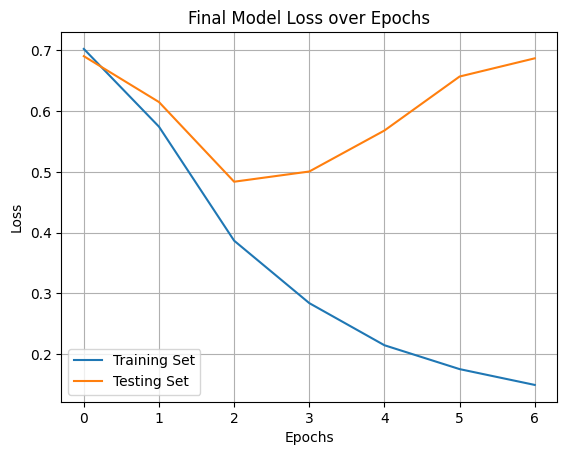

In [75]:
legend = ["Training Set", "Testing Set"]

# Plot the Accuracy
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["val_accuracy"])
plt.title(f"Final Model Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(legend)
plt.grid()
plt.show()

# Plot the Loss
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])
plt.title(f"Final Model Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(legend)
plt.grid()
plt.show()

## Conclusion

### Learnings and Takeaways

From this project I learned about the difficulty in modeling classification algorithms from words in informal formats such as tweets. This problem is inherently difficult for models to pick up on, especially with a limited data set. I learned about all of the different options available for use in Keras for RNN's and gained experience in model design iteration and hyperparameter selection. I also gained practice in the encoding of words to a feature vector space which is neccessary in order to train models on text data. In addition, tweets contain relatively short amounts of texts and therefore the benefits of RNN may not be as impactful on tweets as they would be on longer media.

### What helped and didn't help

The experiments helped to gain a better understanding of the options available to use to create this model. That being said, some of the data seemed inconsistent and hard to interpret. This is likely due to the relatively small amount of data availble, and suboptimal assumptions made before performing the experiment.

### What could be done differently for next time
- Learning rate should have been tuned first to improve the clarity of the other experiments. It is possible some trends were missed due to this being experiment 4 and not
experiment 1.
- Compare using multiple different architectures of RNN in the same model (i.e. GRU + LSTM)
- Perform more analysis on the effect on the number of Epochs
- Compare RNN performance against other architectures, like CNN or even just normal supervised learning methods.

In [93]:
# Generate Submission File

predictions = final_model.predict(submission_data_vectorized)
predictions_list = [round(float(i[0])) for i in predictions]

submission_df = pd.DataFrame(
    {'id': ids, 'target': predictions_list}
    )

submission_df.to_csv('submission.csv', index=False)

102/102 [==============================] - 1s 10ms/step
